In [111]:
# import packages
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from keras.layers import Dense, Convolution1D, Convolution2D, MaxPool1D, Flatten, Dropout, AveragePooling1D
from keras.layers import Input
from keras.models import Model, Sequential
#from keras.layers.normalization import BatchNormalization
from keras.layers import BatchNormalization
import keras
import keras.regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.utils import class_weight
from sklearn.utils import resample
import warnings
import os
warnings.filterwarnings('ignore')

In [112]:
# Parameters

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2
EPOCHS = 200
BATCH_SIZE = 16

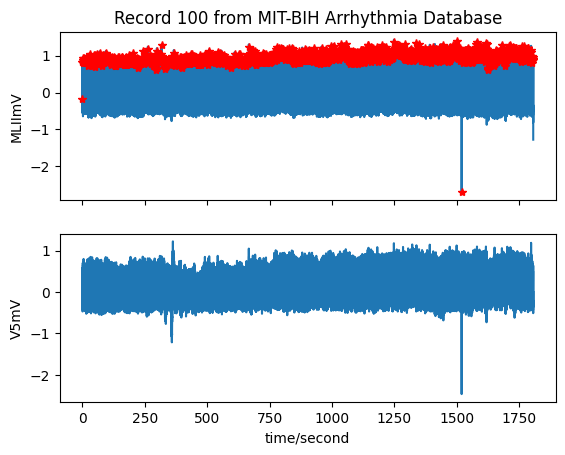

{'record_name': '100',
 'extension': 'atr',
 'sample': array([    18,     77,    370, ..., 649484, 649734, 649991], dtype=int64),
 'symbol': ['+',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'A',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',

[    18     77    370 ... 649484 649734 649991]


In [113]:
import copy
import wfdb
import numpy as np
import pandas as pd
from tsfresh import extract_features, select_features, extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute

SAMPLE_NUM = 11000

#record = wfdb.rdrecord('src/mitdb/100', sampto = SAMPLE_NUM)
#annotation = wfdb.rdann('src/mitdb/100', 'atr', sampto = SAMPLE_NUM)
record = wfdb.rdrecord('src/mitdb/100')
annotation = wfdb.rdann('src/mitdb/100', 'atr')

wfdb.plot_wfdb(record=record, annotation=annotation,
               title='Record 100 from MIT-BIH Arrhythmia Database',
               time_units='seconds')
display(annotation.__dict__)
print(annotation.sample)
#display(record.__dict__)


In [114]:
# Prepare the error vector

# Symbols indicating arrhythmia
#err_list = ['S', 'V', 'F', 'Q']
err_list = ['S', 'V', 'F', 'Q', 'A']
#print(annotation.sample)

# Extract annotation symbols
v_sym = annotation.symbol
v_sym = np.array(v_sym)
v_sym = v_sym[:,None]

# Initialize array of annotations
v_ann = annotation.sample
#y = np.zeros_like(annotation.sample)
y = np.zeros(shape=(len(v_ann)+1), dtype=int)
#print(v_ann)

# Setting to 1 locations where arrhythmia is present
for i in range(len(v_sym)):
    if v_sym[i] in err_list:
        y[i] = 1
    else:
        y[i] = 0

y = pd.Series(y) 
#print(v_sym)
print(v_ann)
print(y)
print(len(y))

[    18     77    370 ... 649484 649734 649991]
0       0
1       0
2       0
3       0
4       0
       ..
2270    0
2271    0
2272    0
2273    0
2274    0
Length: 2275, dtype: int32
2275


In [115]:
v_data = record.p_signal
v_id = np.ones(shape=(v_data[:,0].size,1), dtype=int)
v_time = np.arange(0, v_data[:,0].size, 1, dtype=int)
timeseries = pd.DataFrame({'id': v_id[:,0], 'time': v_time, 'MLII': v_data[:,0]})
print(timeseries.tail())
timeseries.size

        id    time   MLII
649995   1  649995 -0.075
649996   1  649996 -0.445
649997   1  649997 -0.675
649998   1  649998 -0.765
649999   1  649999 -1.280


1950000

In [116]:
# Sample array
array = annotation.sample

# Assigning initial value to id column
timeseries['id'] = 0

# Iterate through the time values
for i in range(len(array)):
    if i == 0:
        timeseries.loc[timeseries['time'] <= array[i], 'id'] = i + 1
    else:
        timeseries.loc[(timeseries['time'] > array[i - 1]) & (timeseries['time'] <= array[i]), 'id'] = i + 1

timeseries.loc[timeseries['time'] > array[-1], 'id'] = len(array) + 1

print(annotation.sample)
print(array)
print(timeseries)

[    18     77    370 ... 649484 649734 649991]
[    18     77    370 ... 649484 649734 649991]
          id    time   MLII
0          1       0 -0.145
1          1       1 -0.145
2          1       2 -0.145
3          1       3 -0.145
4          1       4 -0.145
...      ...     ...    ...
649995  2275  649995 -0.075
649996  2275  649996 -0.445
649997  2275  649997 -0.675
649998  2275  649998 -0.765
649999  2275  649999 -1.280

[650000 rows x 3 columns]


In [117]:
df_train = pd.DataFrame({'temp': ['temp', 'temp', 'temp']})
for i in range(1,2275):
    id = 'id_' + str(i)
    data = timeseries.loc[timeseries['id'] == i, 'MLII'].to_numpy()
    additional = pd.DataFrame({id: data})
    #print(data)
    #print(additional)
    #df_train.insert(i, id, additional)
    df_train = pd.concat([df_train, additional], axis=1) 
df_train = df_train.drop('temp', axis=1)
df_train = df_train.replace(np.NaN, 0)
print(df_train)
    

      id_1   id_2   id_3   id_4  id_5   id_6   id_7   id_8   id_9  id_10  ...  \
0   -0.145 -0.155  0.765  0.905  0.96  0.860  0.780  0.795  0.920  0.875  ...   
1   -0.145 -0.175  0.520  0.755  0.85  0.770  0.535  0.520  0.775  0.735  ...   
2   -0.145 -0.180  0.170  0.490  0.52  0.475  0.145  0.130  0.445  0.400  ...   
3   -0.145 -0.190 -0.165  0.165  0.05  0.065 -0.200 -0.215  0.020 -0.025  ...   
4   -0.145 -0.180 -0.365 -0.110 -0.32 -0.305 -0.420 -0.425 -0.295 -0.335  ...   
..     ...    ...    ...    ...   ...    ...    ...    ...    ...    ...  ...   
402  0.000  0.000  0.000  0.000  0.00  0.000  0.000  0.000  0.000  0.000  ...   
403  0.000  0.000  0.000  0.000  0.00  0.000  0.000  0.000  0.000  0.000  ...   
404  0.000  0.000  0.000  0.000  0.00  0.000  0.000  0.000  0.000  0.000  ...   
405  0.000  0.000  0.000  0.000  0.00  0.000  0.000  0.000  0.000  0.000  ...   
406  0.000  0.000  0.000  0.000  0.00  0.000  0.000  0.000  0.000  0.000  ...   

     id_2265  id_2266  id_2

In [118]:
df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In [119]:
scaler = StandardScaler().fit(df_train)
df_train_rescaled = scaler.transform(df_train)
df_valid_rescaled = scaler.transform(df_valid)

In [120]:
#input_dim=(X_train.shape[1],1)
input_dim = df_train_rescaled.shape[1]
encoding_dim = int(df_train_rescaled.shape[1]/2)
hidden_dim = int(encoding_dim/2)

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 2274)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 1137)                │       2,586,675 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 568)                 │         646,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 568)                 │         323,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 1137)                │         646,953 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 2274)                │       2,587,812 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,791,016 (25.91 MB)

 Trainable params: 6,791,016 (25.91 MB)

 Non-trainable params: 0 (0.00 B)

In [121]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="./models/autoencoder_classifier.keras",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs/fit/autoencoder',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(df_train_rescaled, df_train_rescaled,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    validation_data=(df_valid_rescaled, df_valid_rescaled),
                    verbose=1,
                    callbacks=[cp, tb]).history

Epoch 1/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.0850 - loss: 0.5637 - val_accuracy: 0.2439 - val_loss: 0.4998
Epoch 2/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.2009 - loss: 0.3675 - val_accuracy: 0.2439 - val_loss: 0.3256
Epoch 3/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.2167 - loss: 0.2262 - val_accuracy: 0.2439 - val_loss: 0.2940
Epoch 4/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.1867 - loss: 0.2298 - val_accuracy: 0.2561 - val_loss: 0.2266
Epoch 5/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.2172 - loss: 0.1511 - val_accuracy: 0.2561 - val_loss: 0.2116
Epoch 6/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.2299 - loss: 0.1409 - val_accuracy: 0.2561 - val_loss: 0.2251
Epoch 7/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.2074 - loss: 0.1483 - val_accuracy: 0.2683 - val_loss: 0.1862
Epoch 8/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.2657 - loss: 0.1591 - val_accuracy: 0.